## Data preprocess

In [1]:
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
import sklearn.metrics as sm

In [2]:
data = pd.read_excel('data/TypeClassify.xlsx')
data = data.sample(frac=1)

y_labels = [str(item) for item in data.CAT.value_counts().index.tolist()]
y_labels_to_id = dict([(item, i)for i,item in enumerate(y_labels)])
id_to_y_labels = dict([(i, item)for i,item in enumerate(y_labels)])

print(id_to_y_labels)
print(y_labels_to_id)

{0: '1', 1: '4', 2: '2', 3: '5', 4: '3', 5: '6'}
{'1': 0, '4': 1, '2': 2, '5': 3, '3': 4, '6': 5}


In [3]:
data.head(2)

,ID,text,CAT,Unnamed: 3,说明,Unnamed: 5
5671,N09-3014,Future work will have to concentrate on this a...,2,NaN,NaN,NaN
7138,N19-1234,"Furthermore, the powerful transformer (Vaswani...",1,NaN,NaN,NaN


array([[<AxesSubplot:title={'center':'len'}>]], dtype=object)

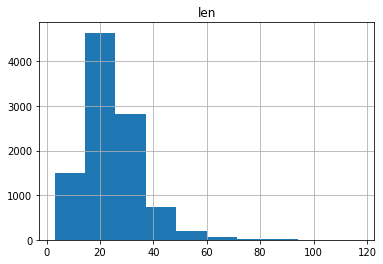

In [4]:
pd.DataFrame({'len':[len(item.split(' ')) for item in data.text.values.tolist()]}).hist()

In [5]:
max_len = 40
t = Tokenizer()
t.fit_on_texts(data.text.values.tolist())
X=pad_sequences(t.texts_to_sequences(data.text.values.tolist()),maxlen=max_len,padding='post')

#将一个label数组转化成one-hot数组。
y = np.eye(len(y_labels_to_id))[[y_labels_to_id[str(item)] for item in data.CAT.values.tolist()]]

In [7]:
vocab_size = len(t.word_index) + 1  #添加<unk>词

In [8]:
import math
n = math.ceil(X.shape[0] * 0.9)
print(n)
train_X = X[:n]
train_y = y[:n]
test_X = X[n:]
test_y = y[n:]
print(train_X.shape)
print(train_y.shape)
print(test_X.shape)
print(test_y.shape)


8955
(8955, 40)
(8955, 6)
(995, 40)
(995, 6)


In [9]:
#要更新tensorflow，否则会报错
# bert 模型
import transformers as tfs
model_class, tokenizer_class, pretrained_weights = (tfs.TFBertForSequenceClassification
                                                    ,tfs.BertTokenizer
                                                    ,'lordtt13/COVID-SciBERT')
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model_bert = model_class.from_pretrained(pretrained_weights, num_labels=6)

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at lordtt13/COVID-SciBERT and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [10]:
import tensorflow as tf
def convert_example_to_feature(review):
    return tokenizer.encode_plus(review, 
                                 add_special_tokens = True, # add [CLS], [SEP]
                                 max_length = max_len, # max length of the text that can go to BERT
                                 pad_to_max_length = True, # add [PAD] tokens
                                 return_attention_mask = True, # add attention mask to not focus on pad tokens
                                )

def map_example_to_dict(input_ids, attention_masks, token_type_ids, label):
    

    return {
      "input_ids": input_ids,
      "token_type_ids": token_type_ids,
      "attention_mask": attention_masks,
  }, label

def encode_examples(ds, frac, is_train = True, limit=-1):
    input_ids_list = []
    token_type_ids_list = []
    attention_mask_list = []
    label_list = []
    if is_train:
        ds = ds.sample(frac=frac)
    if (limit > 0):
        ds = ds.take(limit)
    
    for index, row in ds.iterrows():
        review = row["text"]
        label = y_labels_to_id[str(row["CAT"])]
        bert_input = convert_example_to_feature(review)
  
        input_ids_list.append(bert_input['input_ids'])
        token_type_ids_list.append(bert_input['token_type_ids'])
        attention_mask_list.append(bert_input['attention_mask'])
        label_list.append([label])
    return tf.data.Dataset.from_tensor_slices((input_ids_list, attention_mask_list, token_type_ids_list, label_list)).map(map_example_to_dict)

ds_train_encoded = encode_examples(data,0.9).batch(128)
ds_test_encoded = encode_examples(data,0.1).batch(128)


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.8/dist-packages/transformers/tokenization_utils_base.py:2226: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [11]:
# recommended learning rate for Adam 5e-5, 3e-5, 2e-5
learning_rate = 5e-5
number_of_epochs = 5
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate,epsilon=1e-08, clipnorm=1)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
model_bert.compile(optimizer=optimizer, loss=loss, metrics=[metric])
# fit model
bert_history = model_bert.fit(ds_train_encoded, epochs=number_of_epochs, validation_data=ds_test_encoded)
# model.evaluate(ds_test_encoded)

Epoch 1/5
70/70 [==============================] - 46s 273ms/step - loss: 1.2434 - accuracy: 0.5620 - val_loss: 0.6518 - val_accuracy: 0.7809
Epoch 2/5
70/70 [==============================] - 16s 224ms/step - loss: 0.6970 - accuracy: 0.7583 - val_loss: 0.4525 - val_accuracy: 0.8533
Epoch 3/5
70/70 [==============================] - 16s 224ms/step - loss: 0.5099 - accuracy: 0.8288 - val_loss: 0.3126 - val_accuracy: 0.9035
Epoch 4/5
70/70 [==============================] - 16s 225ms/step - loss: 0.3954 - accuracy: 0.8725 - val_loss: 0.2238 - val_accuracy: 0.9377
Epoch 5/5
70/70 [==============================] - 16s 225ms/step - loss: 0.3532 - accuracy: 0.8830 - val_loss: 0.1891 - val_accuracy: 0.9447


In [16]:
pre ,y_t= [],[]
for i,item in enumerate(ds_test_encoded.as_numpy_iterator()):
#     print(i,item)
#     print(item[0])
#     break
#     print(model_bert.predict(item[0]).logits)
    pre.extend([np.argmax(item) for item in model_bert.predict(item[0]).logits])
    y_t.extend(item[1])
print(sm.classification_report(y_t,pre,digits=4))

              precision    recall  f1-score   support

           0     0.9057    0.9809    0.9418       470
           1     0.9478    0.9007    0.9236       141
           2     0.9633    0.8678    0.9130       121
           3     0.9732    0.8516    0.9083       128
           4     0.9255    0.9775    0.9508        89
           5     1.0000    0.7632    0.8657        38

    accuracy                         0.9301       987
   macro avg     0.9526    0.8903    0.9172       987
weighted avg     0.9329    0.9301    0.9292       987



In [14]:
import transformers as tfs
model_class, tokenizer_class, pretrained_weights = (tfs.TFBertForSequenceClassification
                                                    ,tfs.BertTokenizer
                                                    ,'bert-base-uncased')
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
bert = model_class.from_pretrained(pretrained_weights, num_labels=6)

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [37]:
import tensorflow as tf
def convert_example_to_feature(review):
    return tokenizer.encode_plus(review, 
                                 add_special_tokens = True, # add [CLS], [SEP]
                                 max_length = max_len, # max length of the text that can go to BERT
                                 pad_to_max_length = True, # add [PAD] tokens
                                 return_attention_mask = True, # add attention mask to not focus on pad tokens
                                )

def map_example_to_dict(input_ids, attention_masks, token_type_ids, label):
    return {
      "input_ids": input_ids,
      "token_type_ids": token_type_ids,
      "attention_mask": attention_masks,
  }, label

def encode_examples(ds, frac, is_train = True, limit=-1):
    input_ids_list = []
    token_type_ids_list = []
    attention_mask_list = []
    label_list = []
    if is_train:
        ds = ds.sample(frac=frac)
    if (limit > 0):
        ds = ds.take(limit)
    
    for index, row in ds.iterrows():
        review = row["text"]
        label = y_labels_to_id[str(row["CAT"])]
        bert_input = convert_example_to_feature(review)
  
        input_ids_list.append(bert_input['input_ids'])
        token_type_ids_list.append(bert_input['token_type_ids'])
        attention_mask_list.append(bert_input['attention_mask'])
        label_list.append([label])
    return tf.data.Dataset.from_tensor_slices((input_ids_list, attention_mask_list, token_type_ids_list, label_list)).map(map_example_to_dict)

ds_train_encoded = encode_examples(data,0.9).batch(128)
ds_test_encoded = encode_examples(data,0.1).batch(128)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/miniconda3/envs/dl/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2155: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [38]:
# recommended learning rate for Adam 5e-5, 3e-5, 2e-5
learning_rate = 5e-5
number_of_epochs = 5
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate,epsilon=1e-08, clipnorm=1)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
bert.compile(optimizer=optimizer, loss=loss, metrics=[metric])
# fit model
model_history = bert.fit(ds_train_encoded, epochs=number_of_epochs, validation_data=ds_test_encoded)
# model.evaluate(ds_test_encoded)

Epoch 1/5


70/70 [==============================] - ETA: 0s - loss: 1.4335 - accuracy: 0.4981 WARNING:tensorflow:The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).


70/70 [==============================] - 1367s 19s/step - loss: 1.4313 - accuracy: 0.4989 - val_loss: 0.8896 - val_accuracy: 0.7102
Epoch 2/5
70/70 [==============================] - 1346s 19s/step - loss: 0.8440 - accuracy: 0.7149 - val_loss: 0.6005 - val_accuracy: 0.7984
Epoch 3/5
70/70 [==============================] - 1355s 19s/step - loss: 0.6056 - accuracy: 0.8012 - val_loss: 0.3891 - val_accuracy: 0.8774
Epoch 4/5
70/70 [==============================] - 1367s 20s/step - loss: 0.4454 - accuracy: 0.8610 - val_loss: 0.3401 - val_accuracy: 0.8946
Epoch 5/5
70/70 [==============================] - 1357s 19s/step - loss: 0.3545 - accuracy: 0.8894 - val_loss: 0.3405 - val_accuracy: 0.9007


In [39]:
pre ,y_t= [],[]
for i,item in enumerate(ds_test_encoded.as_numpy_iterator()):
#     print(i,item)
#     print(item[0])
#     break
#     print(model_bert.predict(item[0]).logits)
    pre.extend([np.argmax(item) for item in bert.predict(item[0]).logits])
    y_t.extend(item[1])
print(sm.classification_report(y_t,pre,digits=4))

              precision    recall  f1-score   support

           0     0.8900    0.9742    0.9302       465
           1     0.9440    0.9219    0.9328       128
           2     0.9608    0.8167    0.8829       120
           3     0.9639    0.7619    0.8511       105
           4     0.8045    0.9640    0.8770       111
           5     0.9429    0.5690    0.7097        58

    accuracy                         0.9007       987
   macro avg     0.9177    0.8346    0.8639       987
weighted avg     0.9069    0.9007    0.8974       987



In [18]:
import joblib
from keras.models import load_model
# 模型保存
model_bert.save_weights('bert.h5')
joblib.dump(tokenizer, 'bert.pkl')

# 模型加载
#model = load_model('model_bert.h5')
#tokenizer = joblib.load('model_bert.pkl')


['model_bert.pkl']

In [22]:
test_predict = encode_examples(test_, 1, is_train=False).batch(128)
predict_ = []
tt = []
for i,item in enumerate(test_predict.as_numpy_iterator()): 
    predict_.extend([id_to_y_labels[np.argmax(pre)] for pre in model_bert.predict(item[0]).logits])
    tt.extend(item[0]['input_ids'])

/usr/local/miniconda3/envs/dl/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2155: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [24]:
test_['CAT'] = predict_
test_.to_excel('2020fw.xlsx',index=None)

In [28]:
test_.head()

,ID,chapter,text,CAT
0,2020.acl-demos.1.txt,7 Conclusion,One such important direction for future improv...,1
1,2020.acl-demos.1.txt,7 Conclusion,Another direction for improvement is to furthe...,1
2,2020.acl-demos.10.txt,6 Conclusion,SyntaxGym is continually evolving: we plan to ...,1
3,2020.acl-demos.10.txt,6 Conclusion,"In particular, we plan to incorporate human pe...",1
4,2020.acl-demos.10.txt,6 Conclusion,We also plan to further incorporate language m...,1


In [349]:
 # 校验
print([ ' '.join([tokenizer.ids_to_tokens[item] for item in sentence if item > 0]) for sentence in tt[:3]])
print(predict_[:3])

['[CLS] we are also planning to compare our sense partition ##s with the systematic disagreement obtained by ( wi ##eb ##e , , 1998 ) & ap ##os ; s automatic class ##ifier . [SEP]', '[CLS] another option is to investigate the use of multi - vowel or multi - consonant compounds which better reflect the underlying phonetic units , using an more sophisticated edit distance measure . it is an interesting research question [SEP]', '[CLS] the techniques presented here are useful for language pairs where an on - line translation lexi ##con does not already exist , including the large majority of the world lower - density languages . in both cases , [SEP]']
['3', '1', '4']


# Transformer 模型

In [230]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

class MultiHeadSelfAttention(layers.Layer):
    def __init__(self, embed_dim, num_heads=8):
        super(MultiHeadSelfAttention, self).__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        if embed_dim % num_heads != 0:
            raise ValueError("error")
        self.projection_dim = embed_dim // num_heads
        self.query_dense = layers.Dense(embed_dim)
        self.key_dense = layers.Dense(embed_dim)
        self.value_dense = layers.Dense(embed_dim)
        self.combine_heads = layers.Dense(embed_dim)

    def attention(self, query, key, value):
        score = tf.matmul(query, key, transpose_b=True)
        dim_key = tf.cast(tf.shape(key)[-1], tf.float32)
        scaled_score = score / tf.math.sqrt(dim_key)
        weights = tf.nn.softmax(scaled_score, axis=-1)
        output = tf.matmul(weights, value)
        return output, weights

    def separate_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.projection_dim))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, inputs):
        # x.shape = [batch_size, seq_len, embedding_dim]
        batch_size = tf.shape(inputs)[0]
        query = self.query_dense(inputs)  # (batch_size, seq_len, embed_dim)
        key = self.key_dense(inputs)  # (batch_size, seq_len, embed_dim)
        value = self.value_dense(inputs)  # (batch_size, seq_len, embed_dim)
        query = self.separate_heads(
            query, batch_size
        )   
        key = self.separate_heads(
            key, batch_size
        )   
        value = self.separate_heads(
            value, batch_size
        )   
        attention, weights = self.attention(query, key, value)
        attention = tf.transpose(
            attention, perm=[0, 2, 1, 3]
        )   
        concat_attention = tf.reshape(
            attention, (batch_size, -1, self.embed_dim)
        )   
        output = self.combine_heads(
            concat_attention
        )   
        return output
    
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadSelfAttention(embed_dim, num_heads)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)
    

class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions 

    
vocab_size = len(t.word_index) + 1   
maxlen = 60   

embed_dim = 200   
num_heads = 2   
ff_dim = 32  

inputs = layers.Input(shape=(maxlen,))
embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
x = embedding_layer(inputs)
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(20, activation="relu")(x)
x = layers.Dropout(0.1)(x)
outputs = layers.Dense(6, activation="softmax")(x)

print(inputs)
print(outputs)

model_transformer = keras.Model(inputs=inputs, outputs=outputs)
model_transformer.summary()

Tensor("input_55:0", shape=(None, 60), dtype=float32)
Tensor("dense_63/Softmax:0", shape=(None, 6), dtype=float32)
Model: "functional_61"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_55 (InputLayer)        [(None, 60)]              0         
_________________________________________________________________
token_and_position_embedding (None, 60, 200)           2127200   
_________________________________________________________________
transformer_block_2 (Transfo (None, 60, 200)           174632    
_________________________________________________________________
global_average_pooling1d_2 ( (None, 200)               0         
_________________________________________________________________
dropout_180 (Dropout)        (None, 200)               0         
_________________________________________________________________
dense_62 (Dense)             (None, 20)                4020      
____

In [231]:
model_transformer.compile("adam", "categorical_crossentropy", metrics=["accuracy"])
model_transformer.fit(train_X, train_y, batch_size=256, epochs=6,validation_data=(test_X,test_y))


Epoch 1/6
35/35 [==============================] - 9s 258ms/step - loss: 1.5380 - accuracy: 0.4608 - val_loss: 1.4245 - val_accuracy: 0.4853
Epoch 2/6
35/35 [==============================] - 9s 247ms/step - loss: 1.2633 - accuracy: 0.5356 - val_loss: 1.0978 - val_accuracy: 0.6049
Epoch 3/6
35/35 [==============================] - 8s 233ms/step - loss: 0.7930 - accuracy: 0.7206 - val_loss: 1.0318 - val_accuracy: 0.6657
Epoch 4/6
35/35 [==============================] - 8s 233ms/step - loss: 0.5157 - accuracy: 0.8236 - val_loss: 1.2081 - val_accuracy: 0.6758
Epoch 5/6
35/35 [==============================] - 8s 235ms/step - loss: 0.3413 - accuracy: 0.8878 - val_loss: 1.4168 - val_accuracy: 0.6464
Epoch 6/6
35/35 [==============================] - 8s 234ms/step - loss: 0.2217 - accuracy: 0.9275 - val_loss: 1.5942 - val_accuracy: 0.6140


In [226]:
import numpy as np
pre = model_transformer.predict(test_X)
print(sm.classification_report([np.argmax(item) for item in test_y],[np.argmax(item) for item in pre]))


              precision    recall  f1-score   support

           0       0.70      0.77      0.74       479
           1       0.73      0.52      0.61       132
           2       0.40      0.52      0.45       103
           3       0.50      0.44      0.47       118
           4       0.67      0.54      0.60       113
           5       0.46      0.40      0.43        42

    accuracy                           0.63       987
   macro avg       0.58      0.53      0.55       987
weighted avg       0.64      0.63      0.63       987



# textCNN

In [12]:
from tensorflow.keras.layers import Input,Embedding,Conv1D,MaxPool1D,concatenate,Flatten,Dropout
from tensorflow.keras.layers import Dense,MaxPooling1D,Layer
from tensorflow.keras.models import Model

def TextCNN():
    main_input = Input(shape=(40,))
    # 词嵌入（使用预训练的词向量）
    embed = Embedding(len(t.word_index) + 1, 300, input_length=40)(main_input)
    # 词窗大小分别为3,4,5
    cnn1 = Conv1D(200, 3, padding='same', strides=1, activation='relu')(embed)
    cnn1 = MaxPooling1D(pool_size=38)(cnn1)
    cnn2 = Conv1D(200, 4, padding='same', strides=1, activation='relu')(embed)
    cnn2 = MaxPooling1D(pool_size=37)(cnn2)
    cnn3 = Conv1D(200, 5, padding='same', strides=1, activation='relu')(embed)
    cnn3 = MaxPooling1D(pool_size=36)(cnn3)
    # 合并三个模型的输出向量
    cnn = concatenate([cnn1, cnn2, cnn3], axis=-1)
    flat = Flatten()(cnn)
    drop = Dropout(0.2)(flat)
    main_output = Dense(6, activation='softmax')(drop)
    model = Model(inputs=main_input, outputs=main_output)
    model.summary()
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model
    
model_textcnn = TextCNN()
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)
textcnn_history = model_textcnn.fit(train_X, train_y, batch_size=256, epochs=20,validation_data=(test_X,test_y),callbacks=[early_stop])
# y_predict = list(map(str, result_labels))
# print('准确率', metrics.accuracy_score(y_test, y_predict))
# print('平均f1-score:', metrics.f1_score(y_test, y_predict, average='weighted'))

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 40)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 40, 300)      3204600     input_1[0][0]                    
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 40, 200)      180200      embedding[0][0]                  
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 40, 200)      240200      embedding[0][0]                  
______________________________________________________________________________________________

NotFoundError: 2 root error(s) found.
  (0) Not found:  No algorithm worked!
	 [[node model/conv1d/conv1d (defined at <ipython-input-12-9424afe5c001>:28) ]]
	 [[gradient_tape/model/embedding/embedding_lookup/Reshape/_32]]
  (1) Not found:  No algorithm worked!
	 [[node model/conv1d/conv1d (defined at <ipython-input-12-9424afe5c001>:28) ]]
0 successful operations.
0 derived errors ignored. [Op:__inference_train_function_36347]

Function call stack:
train_function -> train_function


In [29]:
import numpy as np
pre = model_textcnn.predict(test_X)
print(sm.classification_report([np.argmax(item) for item in test_y], [np.argmax(item) for item in pre],digits=4))



              precision    recall  f1-score   support

           0     0.7266    0.8337    0.7765       475
           1     0.7236    0.5933    0.6520       150
           2     0.5798    0.5897    0.5847       117
           3     0.4889    0.4272    0.4560       103
           4     0.7386    0.6566    0.6952        99
           5     0.7273    0.3721    0.4923        43

    accuracy                         0.6879       987
   macro avg     0.6641    0.5788    0.6094       987
weighted avg     0.6852    0.6879    0.6808       987



# BiLSTM

In [30]:
from tensorflow.keras.layers import Bidirectional,LSTM,Layer,Lambda,RepeatVector,Permute,Multiply,BatchNormalization
import tensorflow.keras.backend as K
import tensorflow
# from tensorflow.keras.initializers import 
# Attention GRU network       
from keras import backend as K
from keras.engine.topology import Layer
from keras import initializers, regularizers, constraints

def attention_3d_block(inputs):
    # inputs.shape = (batch_size, time_steps, input_dim)
    input_dim = int(inputs.shape[2])
    a = inputs
    #a = Permute((2, 1))(inputs)
    a = Dense(input_dim, activation='softmax')(a)
    if False:
        a = Lambda(lambda x: K.mean(x, axis=1), name='dim_reduction')(a)
        a = RepeatVector(input_dim)(a)
    a_probs = Permute((1, 2), name='attention_vec')(a)

    output_attention_mul = Multiply()([inputs, a_probs])
    return output_attention_mul
    
def Bilstm():
	# 输入层
    inputs = Input(shape=(40,), dtype='int32')
    # Embedding层
    x = Embedding(len(t.word_index)+1, 300,mask_zero=True)(inputs)
    # BiLSTM层
    x = Bidirectional(LSTM(128, dropout=0.2, return_sequences=True))(x)
    # Attention层
    x = BatchNormalization()(x)
    x = attention_3d_block(x)
    x = Flatten()(x)
    # 输出层
    outputs = Dense(6, activation='softmax')(x)
    model = Model(inputs=inputs, outputs=outputs)
    model.summary() # 输出模型结构和参数数量
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)
model_bilstm1 = Bilstm()
bilstm_history = model_bilstm1.fit(train_X, train_y, batch_size=256, epochs=20,validation_data=(test_X,test_y),callbacks=[early_stop])


Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 40)]         0                                            
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 40, 300)      3172800     input_5[0][0]                    
__________________________________________________________________________________________________
bidirectional_2 (Bidirectional) (None, 40, 256)      439296      embedding_4[0][0]                
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 40, 256)      1024        bidirectional_2[0][0]            
____________________________________________________________________________________________

In [31]:
import numpy as np
pre = model_bilstm1.predict(test_X)
print(sm.classification_report([np.argmax(item) for item in test_y], [np.argmax(item) for item in pre],digits=4))



              precision    recall  f1-score   support

           0     0.7058    0.7726    0.7377       475
           1     0.6269    0.5600    0.5915       150
           2     0.4925    0.5641    0.5259       117
           3     0.4257    0.4175    0.4216       103
           4     0.6463    0.5354    0.5856        99
           5     0.7500    0.2791    0.4068        43

    accuracy                         0.6332       987
   macro avg     0.6079    0.5214    0.5449       987
weighted avg     0.6352    0.6332    0.6277       987



In [38]:
import matplotlib.pyplot as plt

def display(a,b):
    plt.figure(figsize=(10,6))
    plt.title(b)
    for item in a:
        data = item.history[b]
        plt.plot([i for i in range(len(data))],data)
    plt.legend(['model_bert','bert','model_bilstm','model_textcnn'])
    plt.show()

In [34]:
print(textcnn_history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


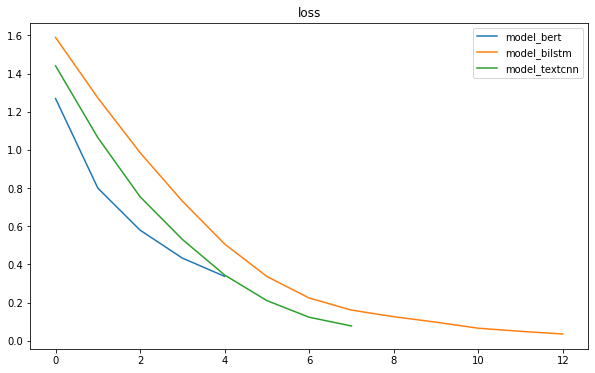

In [39]:
display([bert_history,bilstm_history,textcnn_history],'loss')

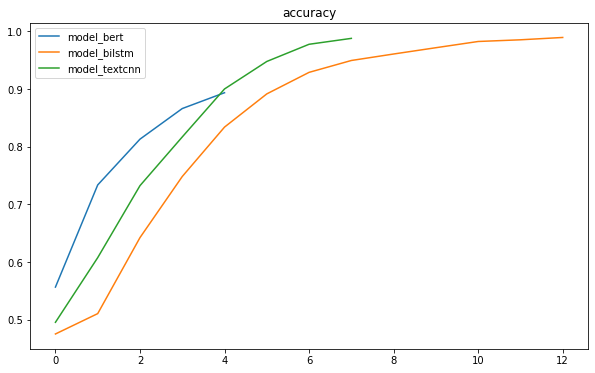

In [40]:
display([bert_history,bilstm_history,textcnn_history],'accuracy')

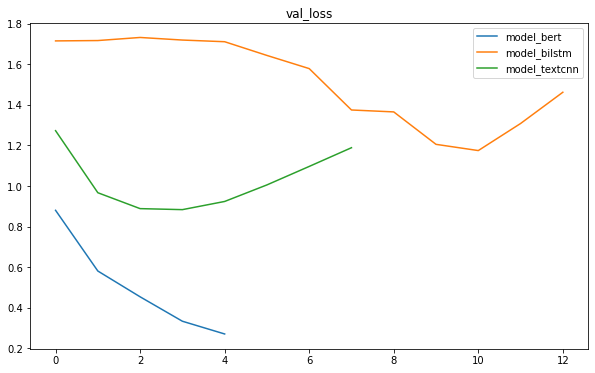

In [41]:
display([bert_history,bilstm_history,textcnn_history],'val_loss')

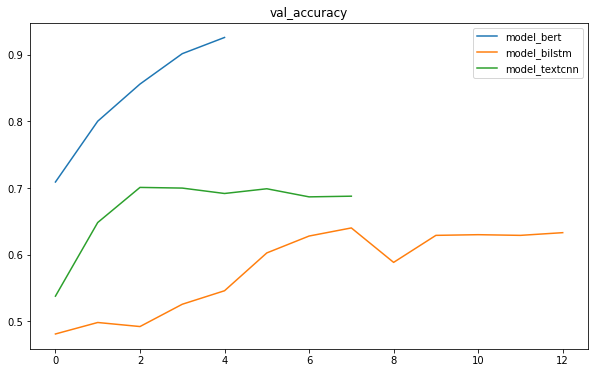

In [42]:
display([bert_history,bilstm_history,textcnn_history],'val_accuracy')